In [1]:
#import all necessary packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 #0.0001
EPOCHS = 10
BS = 32

In [3]:
#map path of the data_set to directory
DIRECTORY = r"/content/drive/MyDrive/archana/People_Face"
CATEGORIES = ["brown_people", "not_brown_people"]

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images

print("...loading images...")


...loading images...


In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224)) #h,w
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
        rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [9]:

# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:

# place the head FC model on top of the base model (this will become
# the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
	layer.trainable = False

In [12]:

# compile our model
print("...compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

...compiling model...


In [13]:
# train the head of the network
print("...training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


...training head...
Epoch 1/10
2/2 [==============================] - 6s 435ms/step - loss: 0.8893 - accuracy: 0.4167
Epoch 2/10
2/2 [==============================] - 2s 2s/step - loss: 0.7326 - accuracy: 0.6111
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.8416 - accuracy: 0.5625
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 0.8003 - accuracy: 0.4722
Epoch 5/10
2/2 [==============================] - 2s 373ms/step - loss: 0.8367 - accuracy: 0.5278
Epoch 6/10
2/2 [==============================] - 2s 260ms/step - loss: 0.7694 - accuracy: 0.5278
Epoch 7/10
2/2 [==============================] - 3s 1s/step - loss: 0.7825 - accuracy: 0.5000
Epoch 8/10
2/2 [==============================] - 3s 1s/step - loss: 0.7293 - accuracy: 0.5781
Epoch 9/10
2/2 [==============================] - 2s 2s/step - loss: 0.7532 - accuracy: 0.5556
Epoch 10/10
2/2 [==============================] - 2s 2s/step - loss: 0.8037 - accuracy: 0.5000


In [14]:
"""import Path
model_structure  = model.to_json()
f = Path("model_structure.json")
f.write_text(model_structure)"""

'import Path\nmodel_structure  = model.to_json()\nf = Path("model_structure.json")\nf.write_text(model_structure)'

In [15]:

# make predictions on the testing set
print("...evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

...evaluating network...
1/1 [==============================] - 1s 1s/step


In [16]:

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability

predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
# show a nicely formatted classification report

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


                  precision    recall  f1-score   support

    brown_people       0.47      0.88      0.61         8
not_brown_people       0.50      0.11      0.18         9

        accuracy                           0.47        17
       macro avg       0.48      0.49      0.40        17
    weighted avg       0.48      0.47      0.38        17



In [18]:

# serialize the model to disk
print("... saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

... saving mask detector model...


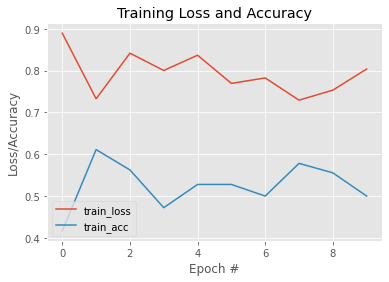

In [19]:

# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

1/1 [==============================] - 0s 144ms/step
Maximum Probability:  0.9269437
Classified: brown_people
Correct_Image


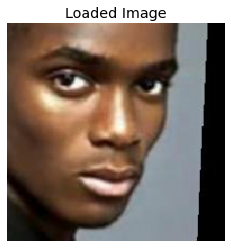

In [26]:
from tensorflow.keras.preprocessing.image import load_img

#img_path = '/content/drive/MyDrive/archana/People_Face/brown_people/20_1_4_20170103225902242.jpg.chip - Copy.jpg'
img_path = '/content/drive/MyDrive/archana/People_Face/brown_people/21_0_1_20170113133115864.jpg.chip - Copy.jpg'
img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0


p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = CATEGORIES[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)
if(predicted_class=="brown_people"):
  print("Correct_Image")
  plt.title("Loaded Image")
  plt.axis('off')
  plt.imshow(img.squeeze())
else:
  print("Incorrect_Image")